In [ ]:
import pandas as pd

# from utils import bcolors

W tym projekcie zajmiemy się technologią, która jest bardzo popularna i przydatna oraz jest jednym z głównych komponentów takich modeli jak ChatGPT - *Language Model* : [Wikipedia](https://en.wikipedia.org/wiki/Language_model)<br>

W dużym uproszczeniu staramy się wypredykować kolejne słowo w danej sekwencji. Pomyślcie o następującym zdaniu:<br><br>
***Mamy dzisiaj bardzo słoneczną ...***<br><br>
Zapewne zdecydowana większość z was zaproponowałaby kończące słowo $pogodę$, być może ktoś zaporponowałby słowo $atmosferę$, ale prawie na pewno nikt nie zaproponowałby słowa $krzesło$.<br>
Uporaszczając właśnie takie zadanie, taką predykcję, wykonują modele takie jak ChatGPT (oczywiście pozwalają one również zadać, która bardziej ogólnie nazywamy promptem). Zatem nasz model ML'owy ma za zadanie wyestymować warunkowy rozkład słów (czyli prawdopodobieństwa dla poszczegółnych słów, wszystkich słów w słowniku) pod warunkiem tej niedokończonej sekwencji:<br><br>
```
P('pogodę' | ['Mamy', 'dzisiaj', 'bardzo', 'słoneczną']) = ?

P('atmosferę' | ['Mamy', 'dzisiaj', 'bardzo', 'słoneczną']) = ?

P('krzesło' | ['Mamy', 'dzisiaj', 'bardzo', 'słoneczną']) = ?
```

Gdyby ktoś poprosił mnie abym oszacował te warnkowe prawdopodobieństwa zapewne przypisałbym następujące wartości (uwaga: to mój subiektywny szacunek, proszę nie traktować tych liczb jako wyliczonych na podstawie jakiś danych, chciałem raczej przekazać różnice pomiędzy tymi prawdopodobieństwami)

```
P('pogodę' | ['Mamy', 'dzisiaj', 'bardzo', 'słoneczną']) = 0.95

P('atmosferę' | ['Mamy', 'dzisiaj', 'bardzo', 'słoneczną']) = 0.03

P('krzesło' | ['Mamy', 'dzisiaj', 'bardzo', 'słoneczną']) ~ 0
```

**Oczywiście gdybyśmy zsumowali te prawdopodobieństwa warunkowe po wszystkich słowach w słowniku to otrzymalibyśmy wartość 1!**<br><br>

Zwykle taki *Language Model* musi być uczony na ogromnych korpusach danych, liczących Terabajty (np. cała wikipedia), my aby zaprezentować podobny mechanizm w naszym projekcie "zejdziemy jedno oczko niżej" - **Zamiast predykować następne słowo w zdaniu będziemy predykować następną literę w wyrazie.** (pomyślcie chociażby ile jest możliwych wszystkich słów w słowniku a ile jest możliwych liter! Takie znaczące zmniejszenie pomoże nam zbudować mały działający model).<br><br>
Nasz *Language model* będzie dotyczył "języka" polskich nazw miejscowości. Za pomocą naszego modelu będziemy mogli generować nowe nazwy polskich miast!

Dane pochodzą z https://dane.gov.pl/pl/dataset/188,wykaz-urzedowych-nazw-miejscowosci-i-ich-czesci

In [ ]:
df_cities = pd.read_csv("PRNG_MIEJSCOWOSCI_05_2021.csv", sep=';')
df_cities

In [ ]:
df_cities['Rodzaj miejscowości'].value_counts()

Do modelu wybieramy tylko nazwy miast. Proszę stworzyć listę, która będzie zawierała nazwy miast, filtrując tę informację na podstawie kolumny `Rodzaj miejscowości`

In [ ]:
list_of_cities = df_cities[df_cities['Rodzaj miejscowości'] == 'miasto']['Główna nazwa miejscowości'].to_list()

list_of_cities[:10]

In [ ]:
len(list_of_cities)

In [ ]:
#rozwiązanie
list_of_cities = df_cities[df_cities['Rodzaj miejscowości'] == 'miasto']['Główna nazwa miejscowości'].tolist()

list_of_cities[:10]

<span style="font-family:Monospace"> ['Aleksandrów Kujawski',<br>
 'Aleksandrów Łódzki',<br>
 'Alwernia',<br>
 'Andrychów',<br>
 'Annopol',<br>
 'Augustów',<br>
 'Babimost',<br>
 'Baborów',<br>
 'Baranów Sandomierski',<br>
 'Barcin'] </span>

Każdą miejscowośc poprzedzamy tokenem sos (start of sentence) i kończymy eos (end of sentence):<br>
```
<sos>Wrocław</eos> 
```
W naszym przypadku umawiamy sie na % i ! - ponieważ model będzie oparty o pojedyncze litery i w takiej sytuacji jest wygodniej gdy specjalne tokeny również są pojedynczymi znakami.<br>
```
%Wrocław!
```
Proszę dodać w naszej liście do każdej nazwy miejscowości na początku symbol `%` a na końcu `!` (polecam użyć list comprehension):

In [ ]:
city_list = ['%' + city + '!' for city in list_of_cities]


city_list[:10]

In [ ]:
#rozwiązanie
city_list = ['%' + city + '!' for city in list_of_cities]

city_list[:10]

<span style="font-family:Monospace"> ['%Aleksandrów Kujawski!',<br>
 '%Aleksandrów Łódzki!',<br>
 '%Alwernia!',<br>
 '%Andrychów!',<br>
 '%Annopol!',<br>
 '%Augustów!',<br>
 '%Babimost!',<br>
 '%Baborów!',<br>
 '%Baranów Sandomierski!',<br>
 '%Barcin!']</span>

No dobrze - w większości mamy już gotowy zestaw danych, nasz "język" miast polskich. Teraz musimy pomyśleć nad modelem, który będzie estymował rozkład warunkowy poszczególnych liter/znaków. Do tego celu wykorzystamy sieci RNN.

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, TimeDistributed, Dense, Dropout, GRU
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.activations import softmax
import tensorflow.keras as keras

In [ ]:
t = "to jest moje przykładowe zdanie"
t.split(" ")

In [ ]:
# resetujemy filtr aby nie usunął tokenów % i !, nie zmniejszamy liter - model ma się nauczyć poprawnej wielkości
tokenizer = Tokenizer(filters='', lower=False, char_level=True)
tokenizer.fit_on_texts(city_list)

# Sprawdzamy ile mamy możliwych znaków ale dodajemy jeszcze jeden, gdyż za chwilę będziemy dodawać znak `0` jako padding
vocab_size = len(tokenizer.word_index) + 1
print(f'Wielkość naszego słownika wynosi: {vocab_size}')
# tokenizer.word_index

Możemy zobaczyć kilka elementów z naszego słownika.<br>
Można też zobaczyć całość wywołując poniższą komendę ale wynik będzie dość długi:
>tokenizer.word_index


In [ ]:
Nth = ['Pierwszy','Drugi','Trzeci', 'Czwarty', 'Piąty', 'Szósty', 'Siódmy']

for nth, items in zip(Nth, tokenizer.word_index.items()):
    print(f'{nth:8} - {items[0]}:{items[1]}')

In [ ]:
# tokenizer.word_index

Teraz czeka nast odpowiednie przygotowanie danych X i Y (objeśniających i objaśnianych) jako wejść do naszego modelu. Spróbujcie przełożyć nasz przykład, mając zdanie:
```
Mamy dzisiaj bardzo słoneczną pogodę
```
Przekształcamy je na:
```
              X                   ->   Y
Mamy dzisiaj bardzo słoneczną ... -> pogodę
```
Bardzo podobnie chcemy zrobić z naszymi nazwami miast:
```
Oryginalne wejście: %Baborów!

W jednej iteracji:
    X    -> Y
%Baborów -> !
P(! | %Baborów)
```
ale także, w jednej iteracji:
```
    X    -> Y
 %Baboró -> w
 P(w | %Baboró)

      X  -> Y
    %Bab -> o
    P(o | %Bab)
```

Okazuje się, że tych wiele iteracji będziemy w stanie zamknąć w jednym przebiegu modelu RNN zatem ostatecznie nie potrzebujemy tych wszystkich kombinacji o różnej długości dla jednej nazwy miasta ale następującego X i Y:
```
    X    ->    Y
%Baborów -> Baborów!
```
Model RNN będzie tak 'sprytny', że na podstawie takiego X i Y będzie niejako liczył po kolei:
```
1. P(B | %)
2. P(a | %B)
3. P(b | %Ba)
...
```

Jeszcze jednym zagadnieniem technicznym jest normalizacja długości wejścia. Chcemy aby do sieci wchodziła macierz gdzie w pierwszj lini jest zakodowana pierwsza miejscowosć (podzielona na poszczegółne litery), w drugiej druga miejscowość itd. Problemem jest fakt, że miejscowości mają różne długości nazw. Zatem po prostu wyznaczymy najdłuższą nazwę miejscowości i dla wszystkich nazw krótyszch niż ona będziemy dodawać same zera na końcu.<br><br> Powoduje to jednak pewnien problem - krótsze nazwy będą składały się w dużej mierze z zer (paddingu). W takiej sytuacju model będzie uczył się że pad trzeba zamienić na pad. Nie jest to zła wiedza natomiast problematyczna z punktu widzenia procesu uczenia się sieci neuronowej - zamiana pad na pad jest bardzo łatwa i nie jest nam do niczego potrzebna. Jeżeli tokeny pad będą uwzględniane przy liczneiu loss to będzie ona sztucznie zaniżona. Np. dla nazwy która w połowie składa się z paddingu, loss będzie zaniżony o połowę. Dlatego w późniejszej części ustawiamy maskowanie - tj ignorowanie klasy o indeksie 0. Nie będzie ona uwzględniana przy liczeniu wartości funkcji straty co da nam bardziej realistyczny obraz sytuacji.<br><br>
Poniżej przykład jak zmienią się nazwy po paddingu:

```
%Babimost!000000000000
%Baranów Sandomierski!

%Baranów Sandomierski
Baranów Sandomierski!

%Babimost000000000000
Babimost!000000000000
```




In [ ]:
X_train = [city[:-1] for city in city_list] # input jest w formacie %Wrocław
y_train = [city[1:] for city in city_list] # output jest w formacie Wrocław!

print(f'example input: {X_train[6]}, example output: {y_train[6]}')

X_train = tokenizer.texts_to_sequences(X_train)
y_train = tokenizer.texts_to_sequences(y_train)

X_train = pad_sequences(X_train, padding='post')
y_train = pad_sequences(y_train, padding='post')

print(f'example input: {X_train[6]}, example output: {y_train[6]}')


In [ ]:
X_train.shape

Dochodzimy do konstruowania modelu. Proszę uzupełnić funkcję \_\_init\_\_ dla klasy LanguageModel zgodnie z podanymi poleceniami.

In [ ]:
class LanguageModel(keras.Model):
    def __init__(self):
        
        # użycie wszystkich elementów inicjalizacji klasy po której dziedziczy nasz klasa, czyli po keras.Model:
        super().__init__(self)
        
        ### Proszę poniżej uzupełnić kod ###
        
        # proszę zainicjalizować warstę Embedding z pakietu keras, z odpowiednim kształtem wejścia (ile "obiektów" 
        # musimy obsłużyć?), wielkością wektora kodującego 128, i flagą dotyczącą maskowania zer na True
        self.embedding = Embedding(vocab_size, output_dim=128, mask_zero=True)
        
        # proszę zainicjalizować warstę GRU (z rodzinny modeli RNN) z pakietu keras, z liczbą jednostek 64, 
        # parametrem do zwracania całej sekwencji oraz paramterem dotyczącym zwracania stanu ukrytego ustawionymi na prawdę
        self.rnn = GRU(64, return_sequences=True, return_state=True)
        
        # proszę zainicjalizować gęstą warstwę z pakietu keras z odpowiednią liczbą wyjść - dla ilu "obiektów" musimy
        # wyznaczyć prawdopodobieństwa warunkowe? Proszę podać poprawną funkcję aktywacji - jaka funkcja najlepiej 
        # reprezentuje rozkład prawdopodobieństwa?
        self.fc = Dense(vocab_size, activation='softmax')
        
        ### Koniec uzupełniania kodu ###
    
    def call(self, inputs, training=False, hidden_state=None, return_state=False): #ta funkcja będzie nam służyła do inferencji
        """
        inputs - wejście w formacie [batch size x max seq len]
        training - parametr określający czy model jest w trakcie fazy treningu
        hidden_state - initial state sieci RNN od którego sieć ma zacząć obliczenia. Jeżeli None - domyślny start
        retur_state - czy użytkownik chce aby zwrócić ostatni hidden state?
        """
        x = inputs
        # wyznaczamy embeddingi czyli wektorowe reprezentacje poszczególnych znaków
        x = self.embedding(x, training=training)

        if hidden_state is None:
            # jeśli nie został podany hidden state to używamy domyślnego, zwykle będzie to wektor samych zer
            hidden_state = self.rnn.get_initial_state(inputs=x)

        # zwróćcie proszę uwagę, że z jednej komórki RNN otrzymujemy 2 zmienne - seq_out i last_hidden_state
        seq_out, last_hidden_state = self.rnn(x, training=training, initial_state=hidden_state)
        # predykujemy rozkład warunkowy jaki powinien być kolejny znak (czyli dokładnie to co oczekiwaliśmy od Language Model)
        x = self.fc(seq_out)

        if return_state:
            # zwracamy predykcję i ostatni stan ukryty
            return x, last_hidden_state
        return x #zwracamy tylko predykcję

    
model = LanguageModel()
model(X_train)
# model.build(input_shape=[None, 1])
model.summary()

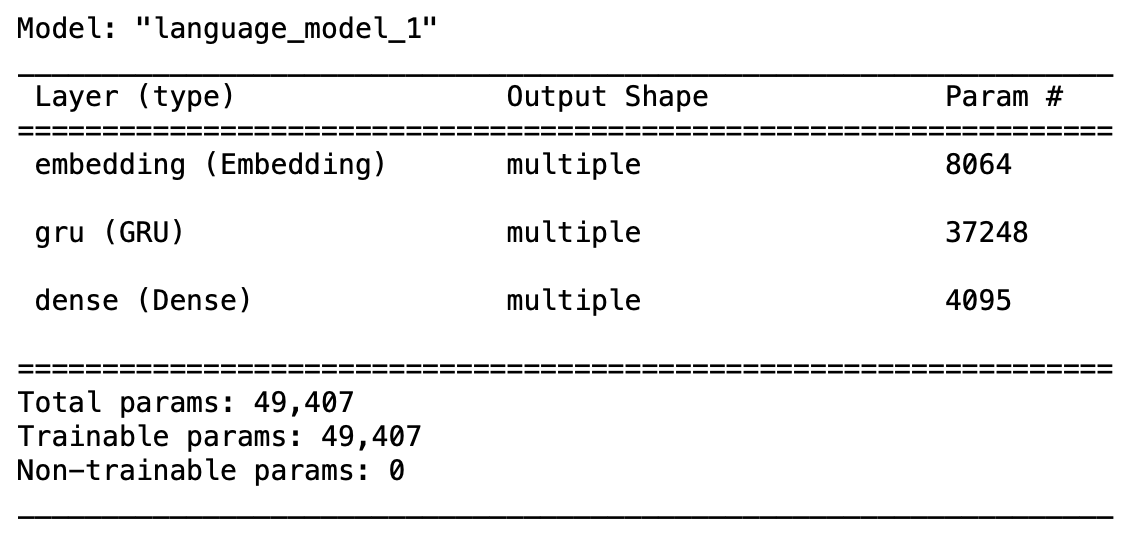

In [ ]:
#rozwiązanie
class LanguageModel(keras.Model):
    def __init__(self):
        super().__init__(self)
        self.embedding = keras.layers.Embedding(vocab_size, output_dim=128, mask_zero=True) # maskowanie zer. Maska propaguje się przez całą sieć automatycznie
        self.rnn = keras.layers.GRU(64, return_sequences=True, return_state=True)
        self.fc = keras.layers.Dense(vocab_size, activation='softmax')
    
    def call(self, inputs, training=False, hidden_state=None, return_state=False): #ta funkcja będzie nam służyła do inferencji
        """
        inputs - wejście w formacie [batch size x max seq len]
        training - parametr określający czy model jest w trakcie fazy treningu
        hidden_state - initial state sieci RNN od którego sieć ma zacząć obliczenia. Jeżeli None - domyślny start
        retur_state - czy użytkownik chce aby zwrócić ostatni hidden state?
        """
        x = inputs
        # wyznaczamy embeddingi czyli wektorowe reprezentacje poszczególnych znaków
        x = self.embedding(x, training=training)

        if hidden_state is None:
            # jeśli nie został podany hidden state to używamy domyślnego, zwykle będzie to wektor samych zer
            hidden_state = self.rnn.get_initial_state(inputs=x)

        # zwróćcie proszę uwagę, że z jednej komórki RNN otrzymujemy 2 zmienne - seq_out i last_hidden_state
        seq_out, last_hidden_state = self.rnn(x, training=training, initial_state=hidden_state)
        # predykujemy rozkład warunkowy jaki powinien być kolejny znak (czyli dokładnie to co oczekiwaliśmy od Language Model)
        x = self.fc(seq_out)

        if return_state:
            # zwracamy predykcję i ostatni stan ukryty
            return x, last_hidden_state
        return x #zwracamy tylko predykcję
    
model = LanguageModel()
model(X_train)
# model.build(input_shape=[None, 1])
model.summary()

In [ ]:
# proszę zainicjalizować błąd potrzebny do treningu modelu - Sparse Categorical Cross-Entropy z pakietu keras
criterion = keras.losses.CategoricalCrossentropy

# proszę skompilować model podając powyższy błąd oraz ustawiając funkcję optymalizującą na 'adam'
model.compile(loss=criterion, optimizer='adam')

# proszę trenować model na odpowiednich danych uczących X i Y przez 150 epok
history = model.fit(x=X_train, y=y_train, epochs=150)

In [ ]:
#rozwiązanie

# proszę zainicjalizować błąd potrzebny do treningu modelu - Sparse Categorical Cross-Entropy z pakietu keras
criterion = keras.losses.SparseCategoricalCrossentropy()

# proszę skompilować model podając powyższy błąd oraz ustawiając funkcję optymalizującą na 'adam'
model.compile(optimizer='adam', loss=criterion)

# proszę trenować model na odpowiednich danych uczących X i Y przez 150 epok
history = model.fit(x=X_train, y=y_train, epochs=150)

Po wytrenowaniu modelu jedyne co nam zostaje to sprawdzić jak działa! Proszę zwrócić uwagę, że jest to model generatywny czyli potrafi generować "nowe" obiekty - w naszej sytuacji nowe nazwy miejscowości.<br><br>
Chciałbym od razu uprzedzić, że niekoniecznie każdy wynik będzie brzmiał jak poprawna nazwa nieistnijącej polskiej miejscowości - czasem będzie niezrozumiałym szumem. Jednak jeśli faza treningu przebiegła poprawnie to przynajmniej część wygenerowanych nazw powinna brzmieć poprawnie.<br><br>
Proszę też zwrócić uwagę jak nietrywialnym jest zagadnienie ewaluacji i pomiaru jakości takiego modelu - proste metryki jak dokładność, F1 itp. nie mają tutaj niestety zastosowania.<br><br>
Zacznijmy od prostej inferencji w której zaczniemy od znaku lub kilku pierwszych znaków zwanych prompt'em lub seed'em. Następnie za pomocą modelu wypredykujemy rozkład jaki znak powinien być kolejny. Na podstawie takiego rozkładu możemy wybrać kolejny znak - albo poprzez losowanie zgodnie z rozkładem, albo wybierając znak z największym prawdopodobieństwem (proszę zwrócić uwagę, że jeśli będziemy wybierać zawsze najwyższe prawdopodobieństwo do nasz wynik będzie zawsze takie sam!). Po ustaleniu kolejnego znaku dodajemy go do naszego prompt'u i ponawamy całą procedurę. Powtarzamy ten kroki albo 30 razy albo jeśli dojedziemy do naszego znaku końca nazwy miejscowości: `!` (model niejako sam "zrozumie", że w tym miejscu nazwa się kończy i nie powinien kontynuować).<br><br>
*Informacyjnie - poza `Greedy search` i `Probabilistic sampling` jest jeszcze `Beam search` - do implementacji dla chetnych.*

In [ ]:
# próbkowanie/inferencja modelu

def sample_model(prompt="%", greedy=False):
    # jeżeli po 30 krokach model nie uzna za stosowne wypredykować tokena </eos> oznaczający koniec, przerywamy. 
    for i in range(30):
        # enkodowanie promptu czyli zamiana znaków na liczby zgodnie z tokenizerem
        encoded_prompt = tokenizer.texts_to_sequences([prompt])
        
        # generujemy predykcję rozkładu znaków pod warunkiem naszego promptu - nasz wytrenowany model
        output = model.predict(encoded_prompt)
        
        # interesuje nas tylko rozkład po ostatnim znaku promptu (jeśli prompt ma więcej niż 1 znak to formalnie
        # model wylicza nam rozkład waunkowy po każdym znaku w prompt'cie, nas interesuje tylko ten po ostatnim),
        # proszę zwrócić uwagę, że batch_size wynosi 1 dlatego odwołujemy się do pierwszej próbki
        last_output = output[0, -1, :]
        
        if greedy:
            #greedy sampling - algorytm zawsze wybierze najbardziej prawdopodobny znak jako kolejny. 
            # W takim scenariuszu generowane nazwy będą zawsze takie same.
            next_char_idx = last_output.argmax()
        else:
            # propabilistic samplig - wylosuj kolejny znak zgodnie z rozkładem prawdopodobieństwa zwróconym przez 
            # model (czyli pewne znaki będą miały większe szanse zostać wylosowane niż inne!). Stosujemy najczęsciej
            next_char_idx = np.random.choice(np.arange(len(last_output)),  p=last_output) 
        
        # tak naprawdę wyznaczyliśmy numer kolejnego znaku - zamień jego indeks na konkretny znak
        next_char = tokenizer.index_word[next_char_idx]
        
        #dodajemy ten znak do promptu
        prompt += next_char
        
        # jeżeli model wyznaczył jako kolejny znak ! to oznacza że skończył samplowanie
        if next_char == '!':
            break
    return prompt




# ustalamy wartość początkową (nazywaną seed/prompt/warmpup text)

prompt = "%" # tylko <sos> - niech model wypluje nazwe na dowolną literę
# można również podać pierwszą lub kilka pierwszych liter:
# prompt = '%Kamil'

print(sample_model(prompt))


In [ ]:
prompt = "%" # tylko <sos> - niech model wypluje nazwe na dowolną literę
# można również podać pierwszą lub kilka pierwszych liter:
# prompt = '%Kamil'

print(sample_model(prompt))

Okazuje się, że jeden z mechanizmów w kodzie powyżej możemy zoptymalizować - nie musimy wywoływać całego modelu za każdym razem z promptem rozszerzanym w każdym kroku o jeden znak. Wystarczy, że zgodnie z ideą sieci RNN przekażamy ostatni stan ukryty, który również może zostać zwrócony z modelu. Ten stan ukryty nazywamu też czasem stanem pamięci modelu i teoretycznie powinien on kodować/pamiętać jaka sekwencja znaków była podana zanim został wygenerowany. Zatem wystarczy, że poza oczywiście zapisywaniem "na boku" naszych kolejnych znaków generowanej nazwy miejscowości, będziemy podawać do naszego modelu ostatni stan ukryty oraz ostatni wygenerowany znak

In [ ]:
# Zaawansowane próbkowanie

def sample_model_optimal(prompt='%', greedy=False):
    # enkodowanie promptu czyli zamiana znaków na liczby zgodnie z tokenizerem
    encoded_prompt = tokenizer.texts_to_sequences([prompt])
    
    #zamiana promptu na tensor - taki format danych będzie poprwnie chodził do modelu
    encoded_prompt = tf.convert_to_tensor(encoded_prompt)
    
    #zadeklarujmy pierwszy stan ukryty, jako domyślny
    hidden_state = None
    
    # podobnie jak wcześniej nie zezwalamy na więcej niż 30 znaków
    for i in range(30):
        
        # predykujemy za pomocą modelu rozkład warunkowy oraz ostatni hidden state. Proszę zwrócić uwagę, że 
        # przekazujemy również stan ukryty podczas wywoływania modelu
        model_out, hidden_state = model(encoded_prompt, return_state=True, hidden_state=hidden_state)
        
        # interesuje nas rozkład po ostanim znaku
        last_output = model_out[0, -1, :].numpy()
        
        if greedy:
            #greedy sampling - algorytm zawsze wybierze najbardziej prawdopodobny znak jako kolejny. 
            # W takim scenariuszu generowane nazwy będą zawsze takie same.
            next_char_idx = last_output.argmax()
        else:
            # propabilistic samplig - wylosuj kolejny znak zgodnie z rozkładem prawdopodobieństwa zwróconym przez 
            # model (czyli pewne znaki będą miały większe szanse zostać wylosowane niż inne!). Stosujemy najczęsciej
            next_char_idx = np.random.choice(np.arange(len(last_output)),  p=last_output) 
            
        # tak naprawdę wyznaczyliśmy numer kolejnego znaku - zamień jego indeks na konkretny znak
        next_char = tokenizer.index_word[next_char_idx]
        
        #dodajemy ten znak do promptu
        prompt += next_char

        # jednak inaczej niż poprzednio kolejne wejście do modelu będzie zawierało TYLKO jeden, ostatnio wygenerowany znak
        encoded_prompt = tokenizer.texts_to_sequences([next_char])

        # zamiana enkodowanego promptu na tensor, który będzie użyty w następnym przebiegu pętli
        encoded_prompt = tf.convert_to_tensor(encoded_prompt)

        # jeżeli model wyznaczył jako kolejny znak ! to oznacza że skończył samplowanie
        if next_char == '!':
            break
    return prompt





# ustalamy wartość początkową (nazywaną seed/prompt/warmpup text)

prompt = "%B" # ustalamy prompt
# można również podać pierwszą lub kilka pierwszych liter:
# prompt = '%Kamil'

print(sample_model_optimal(prompt))

In [ ]:
prompt = "%Kamil" # ustalamy prompt
# można również podać pierwszą lub kilka pierwszych liter:
# prompt = '%Kamil'

print(sample_model_optimal(prompt))

### Kontynuacja

Polecam dalszą pracę z powyższym kodem. Kilka propozycji co można wykonać:
 - Zamiana hiperparametrów modelu tak aby błąd podczas uczenia był jeszcze mniejszy: hyperparameter tuning
 - Wyuczenie modelu języka dla nazw wsi, części miasta, historycznej nazwy miejscowości
 - Beam Search podczas inferencji

In [ ]:
# Jeżeli ktoś się zastanawia jak wygląda rozkład prawdopodobieństwa zwracany przez model to poniższa komórka 
# pokazuje te wartosci znaków dla których pstwo było większe niż 0.001. Najprawdopodobniej największą wartość 
# będzie miał znak `!`, gdyż zapewne przed chwilą zakończył się wykonywać kod generujący, którego ostatnim znakiem
# najczęściej jest `!`. Natomiast można pokusić się o wypisywanie takich prawdopodobieństwa w trakcie generowania
# kolejnych znaków w sekwencji liter - wtedy można zaobserwować jak te wartości się zmieniają dla różnych znaków

for c, i in tokenizer.word_index.items():
    prob = last_output[i]
    if prob > 0.001:
        print(f'{c}:{prob:.3f}')